# Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

# Read in the data

Read the data in from the retail sales CSV file in the examples folder then set the index to the 'date' column. We are also parsing dates in the data file.

In [ ]:
passengers_df = pd.read_excel('AirlinePassengerExercise.xlsx', index_col='Date', parse_dates=True)

FileNotFoundError: ignored

In [ ]:
passengers_df.head(15)

,Year,Month,Passengers,trend
Date,,,,
1949-01-01,1949,1,112.0,124.477715
1949-02-01,1949,2,118.0,125.758071
1949-03-01,1949,3,132.0,126.925837
1949-04-01,1949,4,129.0,128.231374
1949-05-01,1949,5,121.0,129.507581
1949-06-01,1949,6,135.0,130.839673
1949-07-01,1949,7,148.0,132.141839
1949-08-01,1949,8,148.0,133.501027
1949-09-01,1949,9,136.0,134.874195


# Prepare for Prophet

For prophet to work, we need to change the names of these columns to 'ds' and 'y', so lets just create a new dataframe and keep our old one handy (you'll see why later). The new dataframe will initially be created with an integer index so we can rename the columns

In [ ]:
df = passengers_df.reset_index()

In [ ]:
df.head()

,Date,Year,Month,Passengers,trend
0,1949-01-01,1949,1,112.0,124.477715
1,1949-02-01,1949,2,118.0,125.758071
2,1949-03-01,1949,3,132.0,126.925837
3,1949-04-01,1949,4,129.0,128.231374
4,1949-05-01,1949,5,121.0,129.507581


Let's rename the columns as required by fbprophet. Additioinally, fbprophet doesn't like the index to be a datetime...it wants to see 'ds' as a non-index column, so we won't set an index differnetly than the integer index.

In [ ]:
df=df.rename(columns={'Date':'ds', 'Passengers':'y'})

In [ ]:
df.head()

,ds,Year,Month,y,trend
0,1949-01-01,1949,1,112.0,124.477715
1,1949-02-01,1949,2,118.0,125.758071
2,1949-03-01,1949,3,132.0,126.925837
3,1949-04-01,1949,4,129.0,128.231374
4,1949-05-01,1949,5,121.0,129.507581


Now's a good time to take a look at your data.  Plot the data using pandas' ```plot``` function

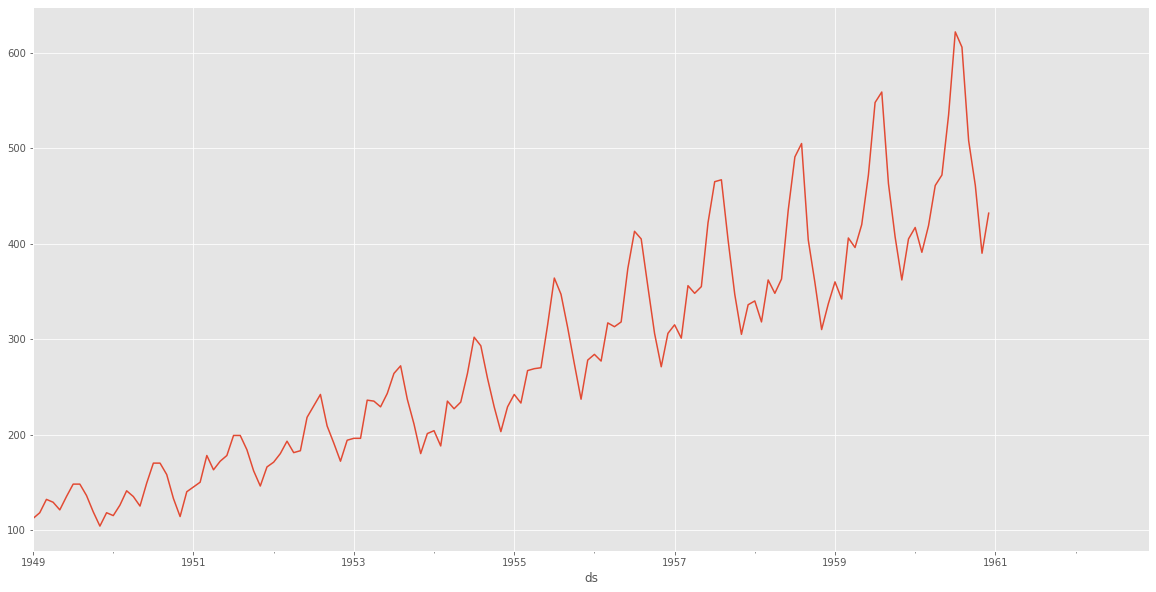

In [ ]:
df.set_index('ds').y.plot()

When working with time-series data, its good to take a look at the data to determine if trends exist, whether it is stationary, has any outliers and/or any other anamolies. Facebook prophet's example uses the log-transform as a way to remove some of these anomolies but it isn't the absolute 'best' way to do this...but given that its the example and a simple data series, I'll follow their lead for now.  Taking the log of a number is easily reversible to be able to see your original data. 

To log-transform your data, you can use numpy's log() function

In [ ]:
df['y'] = np.log(df['y'])

In [ ]:
df.tail()

,ds,Year,Month,y,trend
163,1962-08-01,1962,8,NaN,639.989845
164,1962-09-01,1962,9,NaN,646.572667
165,1962-10-01,1962,10,NaN,653.007603
166,1962-11-01,1962,11,NaN,659.724324
167,1962-12-01,1962,12,NaN,666.290150


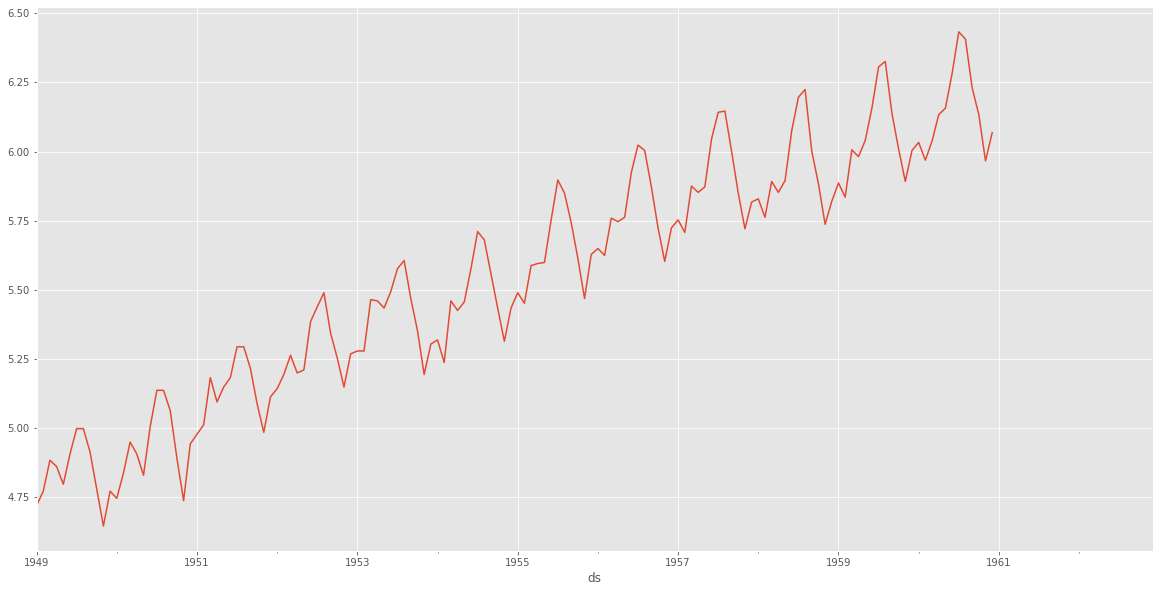

In [ ]:
df.set_index('ds').y.plot()

As you can see in the above chart, the plot looks the same as the first one but just at a different scale.

# Running Prophet

Now, let's set prophet up to begin modeling our data.

Note: Since we are using monthly data, you'll see a message from Prophet saying ```Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.```  This is OK since we are workign with monthly data but you can disable it by using ```weekly_seasonality=True``` in the instantiation of Prophet.

In [ ]:
model = Prophet()
model.fit(df);

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forecasting is fairly useless unless you can look into the future, so we need to add some future dates to our dataframe. For this example, I want to forecast 2 years into the future, so I'll built a future dataframe with 24 periods since we are working with monthly data. Note the ```freq='m'``` inclusion to ensure we are adding 24 months of data.

This can be done with the following code:


In [ ]:
future = model.make_future_dataframe(periods=24, freq = 'm')
future.tail()

,ds
187,1964-07-31
188,1964-08-31
189,1964-09-30
190,1964-10-31
191,1964-11-30


To forecast this future data, we need to run it through Prophet's model.

In [ ]:
forecast = model.predict(future)

The resulting forecast dataframe contains quite a bit of data, but we really only care about a few columns.  First, let's look at the full dataframe:

In [ ]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
187,1964-07-31,6.598844,6.614145,7.007016,6.411431,6.792326,0.211505,0.211505,0.211505,0.211505,0.211505,0.211505,0.0,0.0,0.0,6.810349
188,1964-08-31,6.608037,6.492366,6.896086,6.413071,6.810226,0.077318,0.077318,0.077318,0.077318,0.077318,0.077318,0.0,0.0,0.0,6.685354
189,1964-09-30,6.616933,6.319186,6.749154,6.415139,6.825682,-0.081264,-0.081264,-0.081264,-0.081264,-0.081264,-0.081264,0.0,0.0,0.0,6.535669
190,1964-10-31,6.626126,6.186980,6.620783,6.417111,6.840615,-0.224977,-0.224977,-0.224977,-0.224977,-0.224977,-0.224977,0.0,0.0,0.0,6.401149
191,1964-11-30,6.635022,6.323243,6.769245,6.419380,6.857555,-0.097584,-0.097584,-0.097584,-0.097584,-0.097584,-0.097584,0.0,0.0,0.0,6.537438


We really only want to look at yhat, yhat_lower and yhat_upper, so we can do that with:

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
187,1964-07-31,6.810349,6.614145,7.007016
188,1964-08-31,6.685354,6.492366,6.896086
189,1964-09-30,6.535669,6.319186,6.749154
190,1964-10-31,6.401149,6.186980,6.620783
191,1964-11-30,6.537438,6.323243,6.769245


# Plotting Prophet results

Prophet has a plotting mechanism called ```plot```.  This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

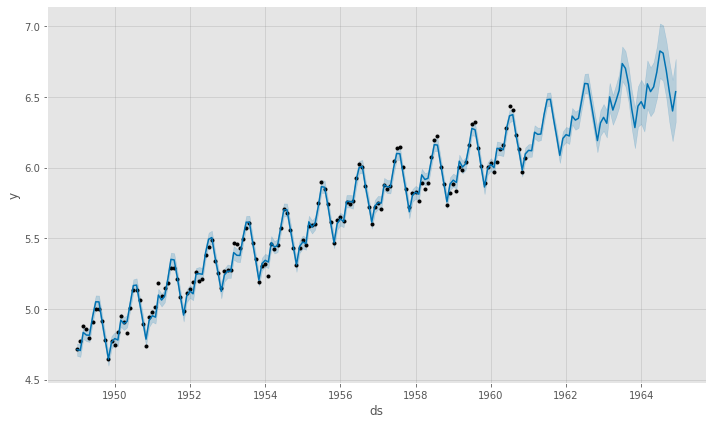

In [ ]:
model.plot(forecast);

Personally, I'm not a fan of this visualization so I like to break the data up and build a chart myself.  The next section describes how I build my own visualization for Prophet modeling 

# Visualizing Prophet models

In order to build a useful dataframe to visualize our model versus our original data, we need to combine the output of the Prophet model with our original data set, then we'll build a new chart manually using pandas and matplotlib.

First, let's set our dataframes to have the same index of ```ds```

In [ ]:
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

Now, we'll combine the original data and our forecast model data

In [ ]:
viz_df = passengers_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

If we look at the ```head()```, we see the data has been joined correctly but the scales of our original data (sales) and our model (yhat) are different. We need to rescale the yhat colums(s) to get the same scale, so we'll use numpy's ```exp``` function to do that.

In [ ]:
viz_df.head()

,Year,Month,Passengers,trend,yhat,yhat_lower,yhat_upper
1949-01-01,1949.0,1.0,112.0,124.477715,4.712282,4.667964,4.755168
1949-02-01,1949.0,2.0,118.0,125.758071,4.706156,4.661288,4.748077
1949-03-01,1949.0,3.0,132.0,126.925837,4.834043,4.787756,4.876656
1949-04-01,1949.0,4.0,129.0,128.231374,4.815340,4.771866,4.860005
1949-05-01,1949.0,5.0,121.0,129.507581,4.814271,4.766993,4.861365


In [ ]:
viz_df['yhat_rescaled'] = np.exp(viz_df['yhat'])

In [ ]:
viz_df.head()

,Year,Month,Passengers,trend,yhat,yhat_lower,yhat_upper,yhat_rescaled
1949-01-01,1949.0,1.0,112.0,124.477715,4.712282,4.667964,4.755168,111.305897
1949-02-01,1949.0,2.0,118.0,125.758071,4.706156,4.661288,4.748077,110.626146
1949-03-01,1949.0,3.0,132.0,126.925837,4.834043,4.787756,4.876656,125.718253
1949-04-01,1949.0,4.0,129.0,128.231374,4.815340,4.771866,4.860005,123.388726
1949-05-01,1949.0,5.0,121.0,129.507581,4.814271,4.766993,4.861365,123.256937


Let's take a look at the ```sales``` and ```yhat_rescaled``` data together in a chart.

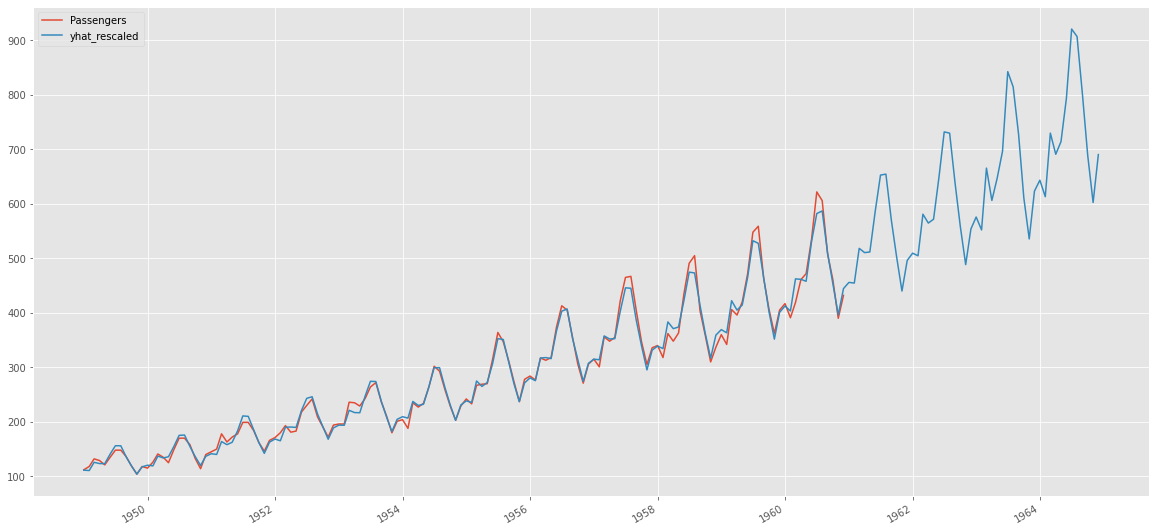

In [ ]:
viz_df[['Passengers', 'yhat_rescaled']].plot()

You can see from the chart that the model (blue) is pretty good when plotted against the actual signal (orange) but I like to make my vizualization's a little better to understand.   To build my 'better' visualization, we'll need to go back to our original ```sales_df``` and ```forecast``` dataframes.

First things first - we need to find the 2nd to last date of the original sales data in ```sales_df``` in order to ensure the original sales data and model data charts are connected. 

In [ ]:
passengers_df.index = pd.to_datetime(passengers_df.index) #make sure our index as a datetime object
connect_date = sales_df.index[-2] #select the 2nd to last date

Using the ```connect_date``` we can now grab only the model data that after that date (you'll see why in a minute). To do this, we'll mask the forecast data.

In [ ]:
mask = (forecast.index > connect_date)
predict_df = forecast.loc[mask]

In [ ]:
predict_df.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
1962-12-01,6.418548,6.227382,6.407097,6.341568,6.490373,-0.101482,-0.101482,-0.101482,-0.101482,-0.101482,-0.101482,0.0,0.0,0.0,6.317066
1962-12-31,6.427444,6.260940,6.450083,6.345446,6.504986,-0.071565,-0.071565,-0.071565,-0.071565,-0.071565,-0.071565,0.0,0.0,0.0,6.355879
1963-01-31,6.436637,6.213474,6.407498,6.349290,6.520283,-0.122669,-0.122669,-0.122669,-0.122669,-0.122669,-0.122669,0.0,0.0,0.0,6.313968
1963-02-28,6.444940,6.399630,6.599554,6.352826,6.531861,0.055828,0.055828,0.055828,0.055828,0.055828,0.055828,0.0,0.0,0.0,6.500767
1963-03-31,6.454133,6.303296,6.513367,6.357968,6.547080,-0.046780,-0.046780,-0.046780,-0.046780,-0.046780,-0.046780,0.0,0.0,0.0,6.407353


Now, let's build a dataframe to use in our new visualization. We'll follow the same steps we did before.

In [ ]:
viz_df = sales_df.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df['yhat_scaled']=np.exp(viz_df['yhat'])

Now, if we take a look at the ```head()``` of ```viz_df``` we'll see 'NaN's everywhere except for our original data rows.  

In [ ]:
viz_df.head()

,Year,Month,Passengers,trend,yhat,yhat_lower,yhat_upper
1949-01-01,1949.0,1.0,112.0,124.477715,4.712282,4.667964,4.755168
1949-02-01,1949.0,2.0,118.0,125.758071,4.706156,4.661288,4.748077
1949-03-01,1949.0,3.0,132.0,126.925837,4.834043,4.787756,4.876656
1949-04-01,1949.0,4.0,129.0,128.231374,4.815340,4.771866,4.860005
1949-05-01,1949.0,5.0,121.0,129.507581,4.814271,4.766993,4.861365


If we take a look at the ```tail()``` of the ```viz_df``` you'll see we have data for the forecasted data and NaN's for the original data series.

In [ ]:
viz_df.tail()

,Year,Month,Passengers,trend,yhat,yhat_lower,yhat_upper
1964-07-31,NaN,NaN,NaN,NaN,6.810349,6.614145,7.007016
1964-08-31,NaN,NaN,NaN,NaN,6.685354,6.492366,6.896086
1964-09-30,NaN,NaN,NaN,NaN,6.535669,6.319186,6.749154
1964-10-31,NaN,NaN,NaN,NaN,6.401149,6.186980,6.620783
1964-11-30,NaN,NaN,NaN,NaN,6.537438,6.323243,6.769245


## time to plot

Now, let's plot everything to get the 'final' visualization of our sales data and forecast with errors.

NameError: ignored

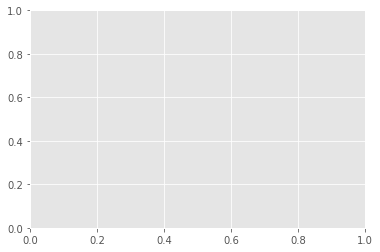

In [3]:
fig, ax1 = plt.subplots()
ax1.plot(viz_df.Passengers)
ax1.plot(viz_df.yhat, color='black', linestyle=':')
ax1.fill_between(viz_df.index, np.exp(viz_df['yhat_upper']), np.exp(viz_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('Sales (Orange) vs Sales Forecast (Black)')
ax1.set_ylabel('Dollar Sales')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend

This visualization is much better (in my opinion) than the default fbprophet plot. It is much easier to quickly understand and describe what's happening. The orange line is actual sales data and the black dotted line is the forecast. The gray shaded area is the uncertaintity estimation of the forecast.